## 2.1 Realizácia predspracovania dát (5b).

- (A-1b) Dáta si rozdeľte na trénovaciu a testovaciu množinu podľa vami preddefinovaného pomeru. Ďalej pracujte len **s trénovacím datasetom**.


In [471]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from pathlib import Path
from sklearn.model_selection import train_test_split
folder = Path("./070")

nacitame data

In [472]:
connections_df = pd.read_csv(folder / "connections.csv", delimiter="\t", parse_dates=['ts'])
devices_df = pd.read_csv(folder / "devices.csv", delimiter="\t")
processes_df = pd.read_csv(folder / "processes.csv", delimiter="\t", parse_dates=['ts'])
profiles_df = pd.read_csv(folder / "profiles.csv", delimiter="\t")

data rozdelime pomocou funkcie train_test_split z sklearn.model v pomere 80:20, random_state zaistuje opakovatelnost aby sme mohli pripadne debugovat

In [473]:
connections_train, connections_test = train_test_split(connections_df, test_size=0.2, random_state=42)
devices_train, devices_test = train_test_split(devices_df, test_size=0.2, random_state=42)
processes_train, processes_test = train_test_split(processes_df, test_size=0.2, random_state=42)
profiles_train, profiles_test = train_test_split(profiles_df, test_size=0.2, random_state=42)

In [474]:
connections_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12054 entries, 13354 to 7270
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ts                 12054 non-null  datetime64[ns]
 1   imei               12054 non-null  int64         
 2   mwra               12054 non-null  float64       
 3   c.android.youtube  12054 non-null  float64       
 4   c.katana           12054 non-null  float64       
 5   c.dogalize         12054 non-null  float64       
 6   c.android.chrome   12054 non-null  float64       
 7   c.android.gm       12054 non-null  float64       
 8   c.UCMobile.x86     12054 non-null  float64       
 9   c.raider           12054 non-null  float64       
 10  c.android.vending  12054 non-null  float64       
 11  c.updateassist     12054 non-null  float64       
 12  c.UCMobile.intl    12054 non-null  float64       
dtypes: datetime64[ns](1), float64(11), int64(1)
memory usage: 1.3 M

In [475]:
devices_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2311 entries, 1835 to 860
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   latitude    2311 non-null   float64
 1   longitude   2311 non-null   float64
 2   store_name  2311 non-null   object 
 3   code        2309 non-null   object 
 4   location    2311 non-null   object 
 5   imei        2311 non-null   int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 126.4+ KB


In [476]:
processes_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12054 entries, 13354 to 7270
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ts                          12054 non-null  datetime64[ns]
 1   imei                        12054 non-null  int64         
 2   mwra                        12054 non-null  float64       
 3   p.android.chrome            12054 non-null  float64       
 4   p.android.documentsui       12054 non-null  float64       
 5   p.android.packageinstaller  12054 non-null  float64       
 6   p.android.settings          12054 non-null  float64       
 7   p.android.gm                12054 non-null  float64       
 8   p.android.externalstorage   12054 non-null  float64       
 9   p.system                    12054 non-null  float64       
 10  p.android.gms               12054 non-null  float64       
 11  p.dogalize                  12054 non-null  float64     

In [477]:
profiles_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2088 entries, 1123 to 860
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   address           1769 non-null   object
 1   job               620 non-null    object
 2   birthdate         1155 non-null   object
 3   name              2088 non-null   object
 4   registration      2088 non-null   object
 5   imei              2088 non-null   int64 
 6   ssn               2088 non-null   object
 7   username          2088 non-null   object
 8   user_id           2088 non-null   int64 
 9   company           2088 non-null   object
 10  current_location  1985 non-null   object
 11  mail              2088 non-null   object
dtypes: int64(2), object(10)
memory usage: 212.1+ KB


- (B-1b) Transformujte dáta na vhodný formát pre ML t.j. jedno pozorovanie musí byť opísané jedným riadkom a každý atribút musí byť v numerickom formáte (encoding). Iteratívne integrujte aj kroky v predspracovaní dát z prvej fázy (missing values, outlier detection) ako celok. 


# ako prve si v kazdom datasete urcime spravne datove typy

In [478]:
devices_train['code'] = devices_train['code'].astype('category')
devices_train['location'] = devices_train['location'].astype('category')

profiles_train['job'] = profiles_train['job'].astype('category')
profiles_train[['latitude', 'longitude']]= (profiles_train['current_location'].str.split(',', expand=True))
# now we have this in both latitude and longitude: (Decimal('-87.0368275') and we need to extract the number from it
profiles_train['latitude'] = profiles_train['latitude'].str.extract(r"(-?\d+\.\d+)")
profiles_train['longitude'] = profiles_train['longitude'].str.extract(r"(-?\d+\.\d+)")
profiles_train['latitude'] = pd.to_numeric(profiles_train['latitude'])
profiles_train['longitude'] = pd.to_numeric(profiles_train['longitude'])

## identifikujeme a vyriesime chybajuce hodnoty

In [479]:
#funkcia ktore pozrie ktore data maju missing values
def has_missing_values(df):
    return df.isnull().any().any()

print('connections_train:', has_missing_values(connections_train))
print('devices_train:', has_missing_values(devices_train))
print('processes_train', has_missing_values(processes_train))
print('profiles_train:', has_missing_values(profiles_train))


# Príklad doplnenia chýbajúcich hodnôt medianom pre číselné stĺpce
# connections_train.fillna(connections_train.median(), inplace=True)

connections_train: False
devices_train: True
processes_train False
profiles_train: True


In [480]:
#dalej osetrime data ktore maju missing values

devices_train['code'] = devices_train['code'].astype('category')

# pridame novu kategoriu pre 2 missing values
devices_train['code'] = devices_train['code'].cat.add_categories(['AC'])

# priradime missing values do novej kategorie
devices_train.loc[devices_train['location'] == 'Africa/Windhoek', 'code'] = 'AC'

print(has_missing_values(devices_train))

False


In [481]:
profiles_train.isnull().sum()

address              319
job                 1468
birthdate            933
name                   0
registration           0
imei                   0
ssn                    0
username               0
user_id                0
company                0
current_location     103
mail                   0
latitude             103
longitude            103
dtype: int64

In [482]:
def identify_outliers(a):
    lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
    upper = a.quantile(0.75) + 1.5 * stats.iqr(a)
    
    return a[(a > upper) | (a < lower)]


def print_outliers_stat(df):
    for column in df:
        # Check if the column is numeric
        if pd.api.types.is_numeric_dtype(df[column]):
            outliers = identify_outliers(df[column])
            print(f'{column}: {len(outliers)} => {(len(outliers) * 100) / len(df[column]):.2f}%')


def remove_outliers(df):
    df_cleaned = df.copy()
    
    for column in df_cleaned.select_dtypes(include=['number']).columns:
        Q1 = df_cleaned[column].quantile(0.25)
        Q3 = df_cleaned[column].quantile(0.75)
        
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df_cleaned = df_cleaned[(df_cleaned[column] >= lower_bound) & (df_cleaned[column] <= upper_bound)]
    
    return df_cleaned

In [483]:
# dalej zistime a osetrime pre kazde numericke data outlierov
print('connections:')
print_outliers_stat(connections_train)

connections:
imei: 0 => 0.00%
mwra: 0 => 0.00%
c.android.youtube: 122 => 1.01%
c.katana: 39 => 0.32%
c.dogalize: 128 => 1.06%
c.android.chrome: 50 => 0.41%
c.android.gm: 7 => 0.06%
c.UCMobile.x86: 0 => 0.00%
c.raider: 0 => 0.00%
c.android.vending: 0 => 0.00%
c.updateassist: 0 => 0.00%
c.UCMobile.intl: 0 => 0.00%


In [484]:
# v tomto pripade mozme dropnut vsetkych outlierov
connections_train = remove_outliers(connections_train)

In [485]:
print('devices:')
print_outliers_stat(devices_train)

devices:
latitude: 62 => 2.68%
longitude: 0 => 0.00%
imei: 0 => 0.00%


In [486]:
# tu nebudeme dropovat outlierov pretoze je to 
# geograficka poloha a nedavalo by to zmysel

In [487]:
print('processes:')
print_outliers_stat(processes_train)

processes:
imei: 0 => 0.00%
mwra: 0 => 0.00%
p.android.chrome: 37 => 0.31%
p.android.documentsui: 9 => 0.07%
p.android.packageinstaller: 26 => 0.22%
p.android.settings: 141 => 1.17%
p.android.gm: 39 => 0.32%
p.android.externalstorage: 178 => 1.48%
p.system: 105 => 0.87%
p.android.gms: 99 => 0.82%
p.dogalize: 1759 => 14.59%
p.process.gapps: 69 => 0.57%
p.katana: 88 => 0.73%
p.google: 75 => 0.62%
p.notifier: 85 => 0.71%
p.android.defcontainer: 0 => 0.00%
p.android.vending: 0 => 0.00%
p.inputmethod.latin: 0 => 0.00%
p.simulator: 0 => 0.00%
p.olauncher: 0 => 0.00%
p.browser.provider: 0 => 0.00%
p.gms.persistent: 0 => 0.00%


In [488]:
# tu najskor nahradime p.dogalize outlierov medianom 
# a potom dropneme ostatne

# toto je tu kvoli warningu
processes_train['p.dogalize'] = processes_train['p.dogalize'].astype(float)
Q1 = processes_train['p.dogalize'].quantile(0.25)
Q3 = processes_train['p.dogalize'].quantile(0.75)
IQR = Q3 - Q1
lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR
median_value = processes_train['p.dogalize'].median()

processes_train.loc[(processes_train['p.dogalize'] < lower_whisker) |
                  (processes_train['p.dogalize'] > upper_whisker)] = median_value

processes_train = remove_outliers(processes_train)

C:\Users\Asus\AppData\Local\Temp\ipykernel_7528\877572124.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.02633' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  processes_train.loc[(processes_train['p.dogalize'] < lower_whisker) |
C:\Users\Asus\AppData\Local\Temp\ipykernel_7528\877572124.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.02633' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  processes_train.loc[(processes_train['p.dogalize'] < lower_whisker) |


In [489]:
print('profiles:')
print_outliers_stat(profiles_train)
# tu netreba nic riesit

profiles:
imei: 0 => 0.00%
user_id: 0 => 0.00%
latitude: 0 => 0.00%
longitude: 0 => 0.00%


## kodovanie ketegorii do numerickeho formatu
pouzijeme LabelEncoder pre atributy s malym poctom kategorii a OneHotEncoder pre viacero kategorii.

In [490]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [491]:
devices_train.info()
# code, location su kategoricke atributy

<class 'pandas.core.frame.DataFrame'>
Index: 2311 entries, 1835 to 860
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   latitude    2311 non-null   float64 
 1   longitude   2311 non-null   float64 
 2   store_name  2311 non-null   object  
 3   code        2311 non-null   category
 4   location    2311 non-null   category
 5   imei        2311 non-null   int64   
dtypes: category(2), float64(2), int64(1), object(1)
memory usage: 109.8+ KB


In [492]:
# pozrieme kolko ich je
print('all data:', devices_train.shape[0])
print('codes:', len(devices_train['code'].unique()))
print('locations:', len(devices_train['location'].unique()))

all data: 2311
codes: 129
locations: 177


In [493]:
# v oboch pripadoch pouzijeme LabelEncoder
le = LabelEncoder()
devices_train['code_encoded'] = le.fit_transform(devices_train['code'])
devices_train['location_encoded'] = le.fit_transform(devices_train['location'])

devices_train.head()

,latitude,longitude,store_name,code,location,imei,code_encoded,location_encoded
1835,15.73628,75.96976,Gajendragarh,IN,Asia/Kolkata,863033069630348875,56,107
965,38.72706,-9.24671,Carnaxide,PT,Europe/Lisbon,8630330696303481479,97,148
1234,31.28092,74.85849,Patti,IN,Asia/Kolkata,3590433799317661412,56,107
662,42.30865,-83.48216,Canton,US,America/Detroit,863033069630348362,120,48
2410,47.49430,-122.24092,Bryn Mawr-Skyway,US,America/Los_Angeles,359043379931766205,120,61


In [494]:

# processes_train, profiles_train ani connections_train nemaju kategoricke atributy

## Zlucenie dat z roznych tabuliek

vieme ze vsetky tabulky maju spolocny atribut imei, ten ale nie je unikatny takze iba na zaklade jeho nemozme tabulky spajat.

unikatny kluc podla ktoreho by sme mohli tabulky spojit je imei + datetime + mwra. Ak spojime tabulky na zaklade tychto atributov dostaneme validny merge

kedze tieto atributy najdeme len v datach connections.csv a processes.csv, budeme joinovat iba tieto tabulky

In [495]:
processes_train['ts'] = pd.to_datetime(processes_train['ts'])
connections_train['ts'] = pd.to_datetime(connections_train['ts'])

In [496]:
merged_data = pd.merge(connections_train, processes_train, on=['imei', 'ts', 'mwra'], how='inner')

print(merged_data.shape)
merged_data.head()

(8446, 33)


,ts,imei,mwra,c.android.youtube,c.katana,c.dogalize,c.android.chrome,c.android.gm,c.UCMobile.x86,c.raider,...,p.katana,p.google,p.notifier,p.android.defcontainer,p.android.vending,p.inputmethod.latin,p.simulator,p.olauncher,p.browser.provider,p.gms.persistent
0,2018-05-14 16:34:00,3590433799317661842,0.0,15.79916,11.89796,7.88379,11.74326,13.52520,66.53684,45.39961,...,73.22345,58.06950,70.03796,40.06228,57.31833,25.24039,11.63406,22.27385,24.61528,44.30657
1,2018-05-11 11:48:00,359043379931766395,0.0,15.66359,9.23880,11.79657,9.70499,7.55193,5.84453,60.93213,...,55.85906,65.12788,49.64248,77.48662,33.67317,64.75537,83.75933,71.70649,12.48423,7.74849
2,2018-05-14 04:14:00,3590433799317661545,0.0,12.31894,10.74263,9.06956,11.36553,16.29064,94.84723,8.02544,...,59.89685,43.70853,70.55336,97.65445,57.29837,35.54874,72.74909,84.64825,65.10023,8.67894
3,2018-05-14 03:57:00,3590433799317662485,1.0,13.81007,12.71315,12.56838,15.48344,15.66407,21.69964,22.91230,...,55.32994,28.28045,56.12538,50.86083,15.63662,93.19556,77.83994,25.63888,62.49013,47.82940
4,2018-05-07 10:44:00,8630330696303481347,0.0,14.29759,11.36878,7.56370,10.13592,11.10431,83.81164,82.12627,...,62.77739,44.25654,40.63453,65.03177,15.96862,82.72673,43.33160,5.39497,61.32340,79.24456


In [497]:
# este rozdeline cas na konkretne atributy, aby
# sme ich pripadne mohli pouzit v ML

# merged_data['year'] = merged_data['ts'].dt.year
# merged_data['month'] = merged_data['ts'].dt.month
# merged_data['day'] = merged_data['ts'].dt.day
# merged_data['hour'] = merged_data['ts'].dt.hour
# merged_data['day_of_week'] = merged_data['ts'].dt.dayofweek
merged_data.drop(['ts'], axis=1, inplace=True)

# TS
Tieto data sme sa rozhodli nepridavat (vid 2.2 A))

In [498]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8446 entries, 0 to 8445
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   imei                        8446 non-null   int64  
 1   mwra                        8446 non-null   float64
 2   c.android.youtube           8446 non-null   float64
 3   c.katana                    8446 non-null   float64
 4   c.dogalize                  8446 non-null   float64
 5   c.android.chrome            8446 non-null   float64
 6   c.android.gm                8446 non-null   float64
 7   c.UCMobile.x86              8446 non-null   float64
 8   c.raider                    8446 non-null   float64
 9   c.android.vending           8446 non-null   float64
 10  c.updateassist              8446 non-null   float64
 11  c.UCMobile.intl             8446 non-null   float64
 12  p.android.chrome            8446 non-null   float64
 13  p.android.documentsui       8446 

## Merged data
Na merged datach vidime ze su vsetky atributy numericke a tak ich mozme vsetky pouzit v ML

- (C-2b) Transformujte atribúty dát pre strojové učenie podľa dostupných techník minimálne: scaling (2 techniky), transformers (2 techniky) a ďalšie. Cieľom je aby ste testovali efekty a vhodne kombinovali v dátovom pipeline (od časti 2.3 a v 3. fáze). 

# import
Importujeme potrebne kniznice

In [499]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer
from sklearn.pipeline import Pipeline

# odklad mwra
Predtym ako budeme skalovat data si odlozime nasu predikovanu hodnotu mwra a v mergnutom datasete ju dropneme

In [500]:
saved_mwra = merged_data['mwra']
merged_data_with_mwra = merged_data
merged_data = merged_data.drop(['mwra'], axis=1)

# 1. technika skalovania
StandardScaler štandardizuje atribúty tak, že ich prevedie na distribúciu s priemerom 0 a štandardnou odchýlkou 1.

In [501]:
scaler_standard = StandardScaler()
scaled_data_standard = scaler_standard.fit_transform(merged_data)
scaled_data_standard

array([[-0.09740973,  0.80176525, -0.43292639, ..., -0.96544494,
        -0.88491853, -0.18276625],
       [-1.06693659,  0.73234236, -1.45994354, ...,  0.74795698,
        -1.30975656, -1.44294634],
       [-0.09740973, -0.98039101, -0.87913637, ...,  1.19653582,
         0.53289332, -1.41087314],
       ...,
       [ 1.41473049,  1.81951186,  1.85833498, ...,  0.08704723,
        -0.48171419,  0.09878159],
       [-0.91572257,  0.2967556 ,  0.08388822, ...,  0.06306851,
         1.71351653, -1.2956292 ],
       [-0.91572257,  0.85657333,  0.9042475 , ...,  0.28447064,
        -1.04595288, -0.63453524]])

# 2. technika skalovania
MinMaxScaler škáluje atribúty do zvoleného rozsahu, napríklad 0 až 1.

In [502]:
scaler_minmax = MinMaxScaler()
scaled_data_minmax = scaler_minmax.fit_transform(merged_data)
scaled_data_minmax

array([[3.90675634e-01, 6.47014302e-01, 4.32709521e-01, ...,
        2.22514662e-01, 2.46152800e-01, 4.42921282e-01],
       [4.85722573e-17, 6.34204280e-01, 2.56981291e-01, ...,
        7.16983420e-01, 1.24842300e-01, 7.72135085e-02],
       [3.90675634e-01, 3.18167988e-01, 3.56360563e-01, ...,
        8.46438290e-01, 6.51002300e-01, 8.65212402e-02],
       ...,
       [1.00000000e+00, 8.34810528e-01, 8.24756827e-01, ...,
        5.26252208e-01, 3.61285900e-01, 5.24627251e-01],
       [6.09324366e-02, 5.53829117e-01, 5.21139317e-01, ...,
        5.19332216e-01, 9.88123700e-01, 1.19965352e-01],
       [6.09324366e-02, 6.57127577e-01, 6.61507260e-01, ...,
        5.83226411e-01, 2.00170200e-01, 3.11816663e-01]])

# 1. technika transformers
PowerTransformer využíva Box-Cox alebo Yeo-Johnson transformáciu na stabilizáciu rozdelenia.

In [503]:
power_transformer = PowerTransformer(method='yeo-johnson')
transformed_data_power = power_transformer.fit_transform(merged_data)
transformed_data_power

c:\Users\Asus\iau_project\venv\Lib\site-packages\numpy\_core\_methods.py:197: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


array([[ 0.29382894,  0.80234257, -0.45344476, ..., -0.91599829,
        -0.82391689, -0.07950938],
       [-1.39821305,  0.73314196, -1.44020306, ...,  0.76463111,
        -1.34833607, -1.54739781],
       [ 0.29382894, -0.98013737, -0.88871049, ...,  1.14085369,
         0.57580625, -1.49839465],
       ...,
       [ 1.20508563,  1.81488441,  1.91632496, ...,  0.17374663,
        -0.38737601,  0.18796978],
       [-0.85394489,  0.29853909,  0.06226098, ...,  0.15129843,
         1.5599033 , -1.33222136],
       [-0.85394489,  0.85696274,  0.90427156, ...,  0.35562187,
        -1.01251487, -0.53982437]])

# 2.technika transformers
QuantileTransformer prevedie distribúciu dát na približne normálnu distribúciu pomocou kvantilov.

In [504]:
quantile_transformer = QuantileTransformer(output_distribution='normal')
transformed_data_quantile = quantile_transformer.fit_transform(merged_data)
transformed_data_quantile

array([[ 0.087933  ,  0.79686687, -0.43877272, ..., -0.7706214 ,
        -0.70918044, -0.14665966],
       [-1.41469767,  0.72205781, -1.40058457, ...,  0.55995924,
        -1.15509426, -1.38564317],
       [ 0.087933  , -0.96151089, -0.84050916, ...,  1.02088364,
         0.40873746, -1.32480899],
       ...,
       [ 1.11636889,  1.81247816,  1.95159389, ...,  0.07173051,
        -0.36254956,  0.05752622],
       [-0.43348197,  0.29070444,  0.01578327, ...,  0.05151381,
         2.25172348, -1.14030633],
       [-0.43348197,  0.8519327 ,  0.89904253, ...,  0.21475134,
        -0.8606559 , -0.47040823]])

- (D-1b) Zdôvodnite Vaše voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie)



# !!!!!! TODO !!!!!! TOTO ESTE SKONTROLOVAT A PREJST/PREPISAT

# Zdokumentovanie a Zdôvodnenie Rozhodnutí pri Transformácii Atribútov

Pri transformácii dát pre strojové učenie je dôležité zabezpečiť, aby atribúty mali vhodnú škálu, boli stabilné a aby ich distribúcia vyhovovala potrebám modelov. Nižšie je uvedené zdôvodnenie zvolených techník transformácie a škálovania.

## 1. Scaling (Škálovanie)
Výber techník škálovania bol motivovaný snahou o optimalizáciu výkonnosti modelov, ktoré často očakávajú normalizované alebo štandardizované vstupy.

### 1.1 StandardScaler
- **Dôvod**: StandardScaler bol zvolený, pretože štandardizuje atribúty na priemer 0 a štandardnú odchýlku 1, čo je vhodné pre algoritmy citlivé na rozsah dát, ako sú SVM, k-means alebo lineárna regresia.
- **Výhoda**: Táto metóda udržuje štatistickú vlastnosť rozdelenia dát a dobre funguje pre dáta, ktoré už majú približne normálne rozdelenie.

### 1.2 MinMaxScaler
- **Dôvod**: MinMaxScaler bol vybraný pre prípady, kde bolo nutné previesť dáta do jednotného rozsahu, napríklad 0 až 1, čo je dôležité pri metódach, ako sú neurónové siete, kde normalizácia atribútov zlepšuje konvergenciu.
- **Výhoda**: Škálovanie do konkrétneho rozsahu môže zvýšiť robustnosť algoritmu voči outlierom a zlepšiť interpretovateľnosť hodnoty každého atribútu.

## 2. Transformers (Transformácie)
Transformácie sme zvolili na stabilizáciu rozdelenia dát a odstránenie šikmosti (skewness), aby sa modely mohli lepšie zamerať na relevantné vzory.

### 2.1 PowerTransformer
- **Dôvod**: PowerTransformer bol zvolený pre svoje schopnosti stabilizovať rozdelenie dát pomocou Yeo-Johnson transformácie. Táto transformácia sa odporúča, ak sú atribúty pozitívne aj negatívne, pričom transformácia stabilizuje šikmosť a robí rozdelenie viac normálnym.
- **Výhoda**: Zlepšenie normality môže pomôcť modelom lineárneho typu a optimalizáciám, ktoré sa opierajú o normálne rozdelenie dát, ako sú regresné modely a PCA.

### 2.2 QuantileTransformer
- **Dôvod**: QuantileTransformer bol zvolený pre svoju schopnosť transformovať rozdelenie dát na normálnu distribúciu bez ohľadu na pôvodné rozdelenie, čo je užitočné pri atribútoch s výraznými odchýlkami.
- **Výhoda**: Táto metóda môže efektívne normalizovať dátové body a je vhodná pre modely citlivé na rozdelenie dát, ako sú algoritmy KNN alebo Bayesovské modely.

## 3. Kombinácia Transformácií v Pipeline
Pipeline bola zostavená na jednoduchšie testovanie a iteratívne kombinácie rôznych techník. Kombinovanie krokov zjednodušuje prácu a zabezpečuje konzistentnú predprípravu dát pre modelovanie.

- **Výhoda pipeline**: Pipeline podporuje opakovateľnosť a konzistenciu v prístupe k predspracovaniu dát. Týmto spôsobom môžeme efektívne otestovať rôzne kombinácie transformácií, vybrať najlepšie varianty a následne ich jednoducho aplikovať na nové dáta alebo testovaciu množinu.

## Celkové zdôvodnenie
Tieto voľby boli zamerané na optimalizáciu dát pre rôzne modely strojového učenia, od lineárnych metód po algoritmy citlivé na rozsah a rozdelenie dát. Skúmanie viacerých techník nám umožňuje prispôsobiť transformáciu atribútov tak, aby maximalizovala výkonnosť a presnosť modelu, čo je cieľom tejto fázy prípravy dát.


## 2.2 Výber atribútov pre strojové učenie (5b)

- (A-3b) Zistite, ktoré atribúty (features) vo vašich dátach pre ML sú informatívne k predikovanej premennej (minimálne 3 techniky s porovnaním medzi sebou). 


# 1. technika Korelacna matica
orelačná matica identifikuje silu vzťahu medzi každým atribútom a cieľovou premennou. Pre číselné atribúty sa často využíva Pearsonova korelácia; vysoká hodnota (kladná alebo záporná) naznačuje informatívnosť atribútu pre predikciu.

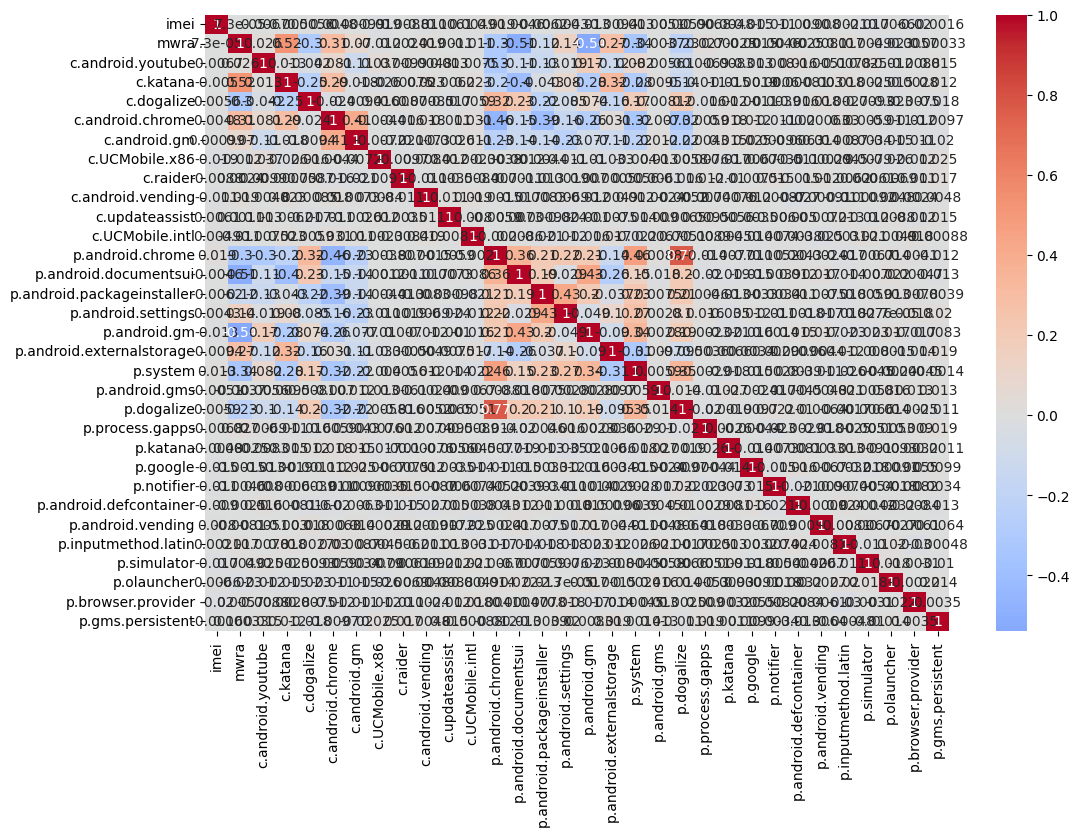

In [505]:
import seaborn as sns
import matplotlib.pyplot as plt

# Vytvorenie korelačnej matice
correlation_matrix = merged_data_with_mwra.corr()

# Vizualizácia korelačnej matice pre zistenie vzťahu k cieľovej premennej mwra
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.show()

korelacna matica je velmi velka, neprehladna a tazko citatelna, preto si vyberieme top 5 najvyssich hodnot k predikovanej premennej mwra

In [506]:
# Výber korelácie pre cieľový stĺpec 'mwra' a zoradenie podľa absolútnej hodnoty
top_5_features = correlation_matrix['mwra'].sort_values(key=abs, ascending=False).head(6)  # 'mwra' bude mať koreláciu 1 so sebou

# Odstránenie 'mwra' zo zoznamu
top_5_features = top_5_features.drop('mwra')

# Zobrazenie top 5 atribútov
print(top_5_features)

p.android.gm            -0.538115
c.katana                 0.521391
p.android.documentsui   -0.512340
p.system                -0.337781
c.android.chrome         0.306397
Name: mwra, dtype: float64


vysledok korelacnej matice mozme vidiet top 5 atributov ktore pravdepodobne vplyvaju na atribut mwra

# 2. technika Random Forest
Použitím modelu Random Forest môžeme zistiť význam atribútov podľa toho, ako často a s akým dopadom sa daný atribút používa pri delení uzlov v rozhodovacích stromoch.

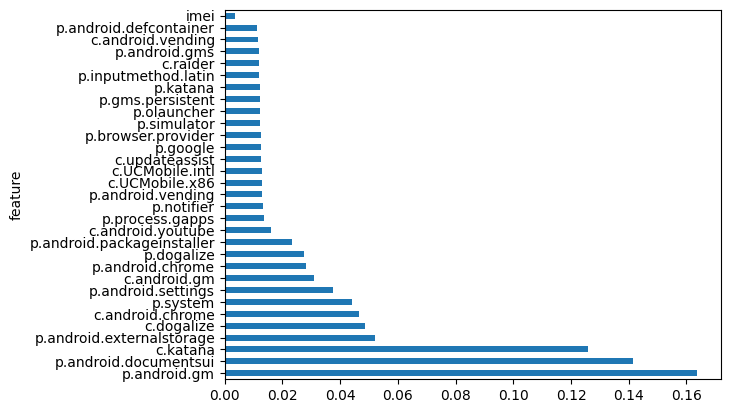

In [507]:
from sklearn.ensemble import RandomForestClassifier

# rozdelenie dataframu na dataframe ktory obsahuje iba mwra
# a taky v ktorom su ostatne atributy
X = merged_data_with_mwra.drop('mwra', axis=1)
y = merged_data_with_mwra['mwra']

# Tréning Random Forest modelu
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# Zobrazenie významu atribútov
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)

# Vizualizácia významu atribútov
feature_importances.plot(kind='barh', x='feature', y='importance', legend=False)
plt.show()

Vysledok random forest mozme vidiet ze na predikciu mwra pravdepodobne vplyvaju atributy (od spodu nahor)

# 3. technika Selektivna metoda s ANOVA
SelectKBest vyberá atribúty podľa štatistických testov. Pre klasifikačné úlohy sa často používa ANOVA alebo Chi-Square (Chi2) test. Táto metóda umožňuje identifikovať atribúty s najvyššou variabilitou voči cieľovej premennej. My pouzijeme Anovu pretoze mame numericke atributy, chi by sme pouzili pri kategorickych

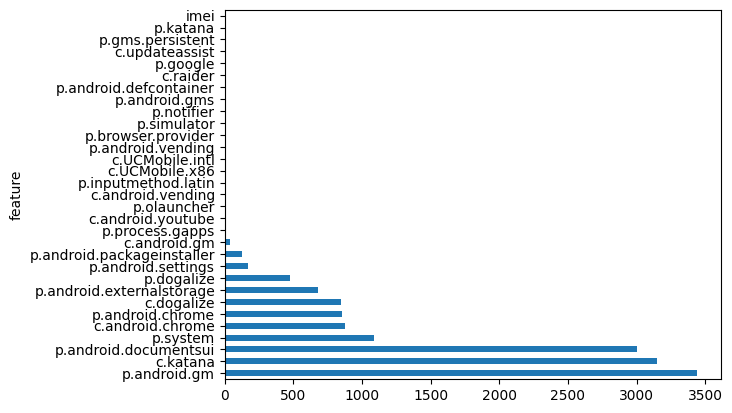

In [508]:
from sklearn.feature_selection import SelectKBest, f_classif

# Použitie ANOVA pre numerické atribúty
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X, y)

# Získanie skóre a zoradenie atribútov podľa informatívnosti
scores = pd.DataFrame({
    'feature': X.columns,
    'score': selector.scores_
}).sort_values(by='score', ascending=False)

# Vizualizácia najlepších atribútov podľa SelectKBest
scores.plot(kind='barh', x='feature', y='score', legend=False)
plt.show()

Vysledok ANOVY mozme vidiet ze na predikciu mwra pravdepodobne vplyvaju atributy (od spodu nahor)

# TS problemy
Vidime warningy ohladom konstantnych hodnotach a problem s delenim. Atributy na ktore sa libka odkazuje su rok a mesiac, takze atributy ktore sme pridali z ts. kezde je s nimi problem a uz v tomto bode si myslime ze nebudu nijak prispievat na predikovanie mwra, tak ich nebudeme na zaciatku ani pridavat do dataframu.

In [509]:
# spájanie výsledkov do jedného DataFrame
importance_df = pd.DataFrame({
    'feature': X.columns,
    'correlation_score': correlation_matrix['mwra'].abs().drop('mwra').values,  # Korelácia s cieľovou premennou
    'random_forest_importance': rf_model.feature_importances_,  # Významnosť podľa Random Forest
    'selectkbest_score': selector.scores_  # Významnosť podľa SelectKBest
})

# Normalizácia skóre na jednotnú mierku
importance_df['correlation_score'] = importance_df['correlation_score'] / importance_df['correlation_score'].max()
importance_df['random_forest_importance'] = importance_df['random_forest_importance'] / importance_df['random_forest_importance'].max()
importance_df['selectkbest_score'] = importance_df['selectkbest_score'] / importance_df['selectkbest_score'].max()

# Vypocet dolezitosti

In [510]:
# Priemerné skóre ako vážená dôležitosť atribútu
importance_df['average_importance'] = importance_df[['correlation_score', 'random_forest_importance', 'selectkbest_score']].mean(axis=1)

importance_df.head()

,feature,correlation_score,random_forest_importance,selectkbest_score,average_importance
0,imei,0.000135,0.021407,1.303277e-08,0.007181
1,c.android.youtube,0.048880,0.097544,1.698588e-03,0.049374
2,c.katana,0.968921,0.769890,9.159628e-01,0.884925
3,c.dogalize,0.561864,0.296694,2.468424e-01,0.368467
4,c.android.chrome,0.569390,0.283296,2.541891e-01,0.368958


# Porovnanie vysledkov Korelacnej matice, Random forest a ANOVA testingu neformalne

- z korelacnej matice vidime ze top 5 atributov je:
1. p.android.gm            -0.538115
2. c.katana                 0.521391
3. p.android.documentsui   -0.512340
4. p.system                -0.337781
5. c.android.chrome         0.306397

- random forest zoberieme iba top 5 atributov pretoze ostatne maju uz velmi slabu hodnotu pre predikciu mwra
1. p.android.gm
2. p.android.documentsui
3. c.katana

- anova taktiez vysli podstatne iba top 3 atributy
1. p.android.gm
2. c.katana
3. p.android.documentsui

- (B-1b) Zoraďte zistené atribúty v poradí podľa dôležitosti. 


# formalne hodnotenie dolezitosti atributov

Zoradíme atribúty podľa vypočítanej priemernej dôležitosti od najdôležitejších po najmenej dôležité. Tieto atribúty predstavujú finálny výber najinformatívnejších premenných.

Ako sme uz vysie spominali, vyberieme prve tri.

In [511]:
# Zoradenie podľa priemernej dôležitosti
importance_df = importance_df.sort_values(by='average_importance', ascending=False)

# Zobrazenie výsledkov
print(importance_df[['feature', 'average_importance']])

                       feature  average_importance
15                p.android.gm            1.000000
12       p.android.documentsui            0.896609
2                     c.katana            0.884925
17                    p.system            0.404271
4             c.android.chrome            0.368958
3                   c.dogalize            0.368467
16   p.android.externalstorage            0.341505
11            p.android.chrome            0.328306
19                  p.dogalize            0.244869
14          p.android.settings            0.179131
13  p.android.packageinstaller            0.134845
5                 c.android.gm            0.109978
1            c.android.youtube            0.049374
20             p.process.gapps            0.044866
28                 p.olauncher            0.039392
26         p.inputmethod.latin            0.035498
8            c.android.vending            0.035360
6               c.UCMobile.x86            0.034080
10             c.UCMobile.intl 

1. p.android.gm
2. p.android.documentsui
3. c.katana

Týmto spôsobom sme zoradili atribúty podľa ich dôležitosti pre cieľovú premennú. Atribúty s najvyšším skóre by mali byť zahrnuté v ďalšom modelovaní, pričom menej dôležité atribúty môžeme odstrániť alebo im prideliť nižšiu prioritu v ďalších analýzach.

- (C-1b) Zdôvodnite Vaše voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie)

# !!!!! TODO !!! TOTO ESTE SKONTROLOVAT ALEBO NEJAK PREPISAT VLASTNYMI SLOVAMI

# Zdokumentovanie a Zdôvodnenie Rozhodnutí pri Výbere a Zoradení Atribútov

Pri výbere a zoradení atribútov sme použili rôzne metódy, aby sme zabezpečili robustnosť výsledkov a optimalizovali model pre predikciu. Nižšie sú uvedené hlavné dôvody výberu použitých techník a prístupu k zoradeniu atribútov.

## 1. Kombinácia Viacerých Techník pre Výber Atribútov
- **Dôvod**: Každá metóda výberu atribútov má svoje špecifiká a klady, a preto kombinácia viacerých techník znižuje riziko nesprávneho výberu a zvýrazňuje atribúty, ktoré sú konzistentne dôležité naprieč rôznymi metódami.
- **Prístup**: Použili sme korelačnú maticu, ktorá poskytuje intuitívny a rýchly prehľad o vzťahoch medzi atribútmi a cieľovou premennou. Random Forest a SelectKBest sme pridali, pretože poskytujú pokročilejšie metódy hodnotenia dôležitosti, pričom využívajú silné stránky štatistických testov a stromových algoritmov.

## 2. Normalizácia a Výpočet Priemernej Dôležitosti
- **Dôvod**: Každá metóda používa rôzne mierky dôležitosti, preto sme výsledky zjednotili cez normalizáciu, aby boli porovnateľné. Výpočet priemernej dôležitosti umožňuje kombinovať výsledky z rôznych metód do jedného koherentného skóre, čo nám dáva spoľahlivý základ na zoradenie atribútov.
- **Prístup**: Normalizované skóre každého atribútu z jednotlivých metód sme použili na výpočet priemernej dôležitosti. Táto metóda zaručuje, že naše konečné poradie nie je ovplyvnené extrémami v jednej z metód, a súčasne zohľadňuje viaceré aspekty dôležitosti.

## 3. Zoradenie Atribútov na základe Priemernej Dôležitosti
- **Dôvod**: Zoradenie podľa priemernej dôležitosti umožňuje zamerať sa na najvýznamnejšie atribúty pri vytváraní modelu, čo vedie k efektívnejšiemu a presnejšiemu modelu.
- **Výhoda pre model**: Zahrnutím najdôležitejších atribútov zvyšujeme presnosť modelu a znižujeme šum v dátach. Na základe tohto poradia môžeme rozhodnúť o odstránení menej dôležitých atribútov, čím znížime riziko nadmerného fitovania a zvýšime generalizovateľnosť modelu.

## Celkové Zdôvodnenie
Tieto rozhodnutia boli navrhnuté s cieľom optimalizovať efektívnosť a interpretabilitu modelu. Použitím viacerých techník a váženého prístupu sme sa snažili zaistiť, že výber atribútov nie je založený na jednej metóde, ale zohľadňuje rozmanité prístupy. Týmto spôsobom sme schopní presnejšie identifikovať najinformatívnejšie atribúty, čo je kľúčové pre dosiahnutie kvalitných výsledkov v ďalšej fáze modelovania.

## 2.3 Replikovateľnosť predspracovania (5b)

- (A-3b) Upravte váš kód realizujúci predspracovanie trénovacej množiny tak, aby ho bolo možné bez ďalších úprav znovu použiť **na predspracovanie testovacej množiny** v kontexte strojového učenia.


- (B-2b) Využite možnosti **sklearn.pipeline**